###  dataset https://www.consumerfinance.gov/data-research/
https://www.consumerfinance.gov/data-research/consumer-complaints/

What the consumers were complaining in the financial product and service market? 
Data from these complaints help us understand the financial marketplace and protect consumers.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import Window
from pyspark.sql import SQLContext
#from pyspark.sql.functions import col, udf
import pyspark.sql.functions as F
from pyspark.sql.functions import split, explode
#from pyspark.sql.functions import regexp_replace, trim, col, lower
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, TimestampType,ArrayType

from pyspark.ml.feature import Tokenizer, RegexTokenizer

NLP related installation and import

In [0]:
#word cloud
!pip install wordcloud
from wordcloud import WordCloud 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [0]:
#!/bin/bash
!pip install nltk
!pip install --upgrade pip
!nltk.downloader all

import nltk
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('ieer')
nltk.download('stopwords')
#stopwords = set(STOPWORDS) 
stopwords = nltk.corpus.stopwords.words('english')
english_words = set(nltk.corpus.words.words())
#########
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data] Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data] Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data] /root/nltk_data...
[nltk_data] Package averaged_perceptron_tagger is already up-to-
[nltk_data] date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data] /root/nltk_data...
[nltk_data] Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data] Package words is already up-to-date!
[nltk_data] Downloading package ieer to /root/nltk_data...
[nltk_data] Package ieer is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!

In [0]:
#palette for seaborn
palette_colors = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878',
                    '#A040A0', '#F8D030','#E0C068','#EE99AC','#C03028', 
                    '#F85888', '#B8A038','#705898','#98D8D8','#7038F8']

#### 1.1 Data acquisition
- download [json format datasource](http://files.consumerfinance.gov/ccdb/complaints.json.zip) to local storage and unzip. Upload the unzipped json file to DBFS
- read json file and partion by 
- create dellta table. Delta Engine is a high performance, Apache Spark compatible query engine that provides an efficient way to process data in data lakes including data stored in open source Delta Lake. Delta Engine optimizations accelerate data lake operations, supporting a variety of workloads ranging from large-scale ETL processing to ad-hoc, interactive queries.

In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/"))

path,name,size
dbfs:/FileStore/tables/complaints.csv,complaints.csv,1233411049
dbfs:/FileStore/tables/complaints.json,complaints.json,1942366519
dbfs:/FileStore/tables/exercise_pyspark_dataframe.ipynb,exercise_pyspark_dataframe.ipynb,30542
dbfs:/FileStore/tables/flight_model/,flight_model/,0
dbfs:/FileStore/tables/flight_weather.csv,flight_weather.csv,431664555


#####1.1.1 Pick up few data for observation.
Here we can see the 4 types of data data fields:
- date columns (yyyy-mm-dd format)
- some categorical columns
- narrative column (sentences)
- location related columns (state, zipcode)

In [0]:
# have quick view of the content of this json file
dbutils.fs.head("dbfs:/FileStore/tables/complaints.json", 4096)  

[Truncated to first 4096 bytes]
Out[6]: '[\n{"date_received": "2019-09-24", "product": "Debt collection", "sub_product": "I do not know", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt is not yours", "complaint_what_happened": "transworld systems inc. \\nis trying to collect a debt that is not mine, not owed and is inaccurate.", "company_public_response": "", "company": "TRANSWORLD SYSTEMS INC", "state": "FL", "zip_code": "335XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-24", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3384392"},\n{"date_received": "2019-09-19", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Incorrect information on your report", "sub_issue": "Information belongs to someone else", "complaint_what_happened": "", "company_public_response": "Company has responded to the consumer and the CFPB and chooses not to provide a public response", "company": "Experian Information Solutions Inc.", "state": "PA", "zip_code": "15206", "tags": "", "consumer_consent_provided": "Consent not provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-20", "company_response": "Closed with non-monetary relief", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3379500"},\n{"date_received": "2019-11-08", "product": "Debt collection", "sub_product": "I do not know", "issue": "Communication tactics", "sub_issue": "Frequent or repeated calls", "complaint_what_happened": "Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.", "company_public_response": "", "company": "Diversified Consultants, Inc.", "state": "NC", "zip_code": "275XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-11-08", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3433198"},\n{"date_received": "2021-01-28", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Problem with a credit reporting company\'s investigation into an existing problem", "sub_issue": "Investigation took more than 30 days", "complaint_what_happened": "", "company_public_response": "", "company": "EQUIFAX, INC.", "state": "FL", "zip_code": "33432", "tags": "", "consumer_consent_provided": "", "submitted_via": "Web", "date_sent_to_company": "2021-01-28", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "4102456"},\n{"date_received": "2019-09-15", "product": "Debt collection", "sub_product": "Other debt", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt was result of identity theft", "complaint_what_happened": "Pioneer has committed several federal violations against me, a Private law abiding Federally Protected Consumer. Each violation is a statutory cost of {$1000.00} each, which does not include my personal cost and fees which shall be determined for taking time to address these issues. Violations committed against me include but not limited to : ( 1 ) Violated 15 USC 1692c ( a ) ; Communication without prior consent, expressed permission. ( 2 ) Violated 15 USC 1692d ; Harass and oppressive use of intercourse about an alleged debt. ( 3 ) Violated 15 USC 1692d ( l ) ; Attacking my reputation, accusing me of owing an alleged debt to you. ( 4 ) Violated 15 USC 1692e ( 9 ) ; Use/distribution of communication with auth

##### 1.1.2 load data into dataframe

In [0]:
from pyspark.sql.types import DateType
file_name = '/FileStore/tables/complaints.json'
#For a regular multi-line JSON file, set the multiLine option to true.
schema = """ `date_received`  DATE, 
`product`  STRING, 
`sub_product`  STRING, 
`issue`  STRING, 
`sub_issue`  STRING, 
`complaint_what_happened`  STRING, 
`company_public_response`  STRING, 
`company`  STRING, 
`state`  STRING, 
`zip_code`  STRING, 
`tags`  STRING, 
`consumer_consent_provided`  STRING, 
`submitted_via`  STRING, 
`date_sent_to_company`  DATE, 
`company_response`  STRING, 
`timely`  STRING, 
`consumer_disputed`  STRING, 
`complaint_id`  STRING""" 

df = spark.read.option("multiline",True).\
  json("/FileStore/tables/complaints.json", schema=schema)

#df = df.withColumn("complaint_id", df["complaint_id"].cast("bigint"))

In [0]:
total = df.count()
#dana volumn
print((total, len(df.columns)))
#take 5 rows and have a clearer view with pandas dataframe
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
date_received,2019-09-24,2019-09-19,2019-11-08,2021-01-28,2019-09-15
product,Debt collection,"Credit reporting, credit repair services, or o...",Debt collection,"Credit reporting, credit repair services, or o...",Debt collection
sub_product,I do not know,Credit reporting,I do not know,Credit reporting,Other debt
issue,Attempts to collect debt not owed,Incorrect information on your report,Communication tactics,Problem with a credit reporting company's inve...,Attempts to collect debt not owed
sub_issue,Debt is not yours,Information belongs to someone else,Frequent or repeated calls,Investigation took more than 30 days,Debt was result of identity theft
complaint_what_happened,transworld systems inc. \nis trying to collect...,,"Over the past 2 weeks, I have been receiving e...",,Pioneer has committed several federal violatio...
company_public_response,,Company has responded to the consumer and the ...,,,
company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.,"Diversified Consultants, Inc.","EQUIFAX, INC.",Pioneer Capital Solutions Inc
state,FL,PA,NC,FL,CA
zip_code,335XX,15206,275XX,33432,925XX


#### 1.2 Data cleansing
- Check date range, only keep the sent date from 2012-01-01 to 2019-12-31 (keep full-year data and exclude influence of covid-19)
- Delete data withought primary key (Complaint ID)
- remove empty states and outliers name

In [0]:
display(df.product.unique())


--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-3688459704639834> in <module> 
 ----> 1 display ( df . product . unique ( ) ) 

 TypeError : 'Column' object is not callable

In [0]:
#categorical field 
mapping= {
        'A': '1',
        'B': '2'
    }
df2 = df.replace(to_replace=mapping, subset=['yourColName'])
#mapTypeDF.select(col("name"),map_keys(col("properties"))).show(false)
#这种替换值的办法比较好，但是会直接替掉之前的值，不过既然已经有了映射表，替换也无所谓

In [0]:
#https://blog.csdn.net/sinat_26917383/article/details/80500349
# delete null rows of these categorical columns, delete empty state and an outlier
df = df.filter("date_received>'2011-12-31' and date_received<'2020-01-01' " +
        "and state !='' and state!='UNITED STATES MINOR OUTLYING ISLANDS' ").\
        dropna(subset=['complaint_id', 'issue','product','date_received','company','state','submitted_via'])
# save cleaned data to table.
df.createOrReplaceTempView('t_complaints')

#### 1.3 Data transformation

##### 1.3.1 Convert categorical columns to numeric 
- process all categorical columns, generate _index column. Converts these columns of string values to label indexes.

In [0]:
Credit reporting, credit repair services, or other personal consumer reports

sqlContext.sql("SELECT product GROUP BY product")

In [0]:
#these are some categorical string columns, add according code column to make it easier to process
"""
for machine learning
cat_columns = ['product','sub_product',\
               'issue','sub_issue',\
               'submitted_via','company','company_response',\
               'consumer_consent_provided','timely']

cat_columns = ['product','sub_product',\
               'issue','sub_issue']
#pipeline
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in cat_columns ]
pipeline = Pipeline(stages=indexers)
#coresponding *_index columns are added to the new dataframe
df = pipeline.fit(df).transform(df)
"""           

File "<command-4181774045639223>" , line 1 
 import pyspark.ml.* 
 ^
 SyntaxError : invalid syntax

#### 2.1 Data visualization

#####2.1.1 What are the most complained by multiple dimensions, have they changed over time. 
- by product by year
- by submitted channel by year
- by company by year
- by issue by year

In [0]:
#we need to count group by year by each dimension, get the top rank items in each year, and visualize them with grouped chart. The below functions are for dealing with this issue. genChart
# for generating chart dataset

#generate group bar chart
def genBarchart(name, group_field_name, top_n=4):
  df = getRankByYear(group_field_name)
  years = df["sent_year"].unique()
  #begin year
  year1 = years[0];
  #end year
  year2 = years[-1]
  with sns.axes_style('white'):
    #show complaints amount by group_field_name by year
    g = sns.factorplot(x="sent_year", y="count", data=df, aspect=3.0, kind='bar',
                       palette=palette_colors,ci=None,hue=group_field_name, 
                       order=range(year1,year2),sharex=False,legend_out=False)
    g.set_ylabels('complaints amount')
    plt.legend(loc='best')
    #title - top n complaints by xxx begin_year - end_year
    g.fig.suptitle('top {} complaints by {} {} - {}'.format(top_n,name,year1,year2))
    
def getRankByYear(field_name, top_n=4):
  #top n complaints amount by year by field_name
  df_topn = sqlContext.sql("SELECT year(date_received) as sent_year," + \
                  field_name +\
                  " ,count(1) AS count " +\
                  " FROM t_complaints " +\
                  " GROUP BY year(date_received)," + field_name)
  w = Window.partitionBy("sent_year").orderBy(F.col("count").desc())
  df_topn_pd = df_topn.select("*",F.row_number().over(w).alias('rank')).\
    filter(F.col('rank') <= top_n).orderBy(F.col("sent_year")).toPandas()
  return df_topn_pd

###### 2.1.1.1 Where did the complaints come from? Did that changed over time?

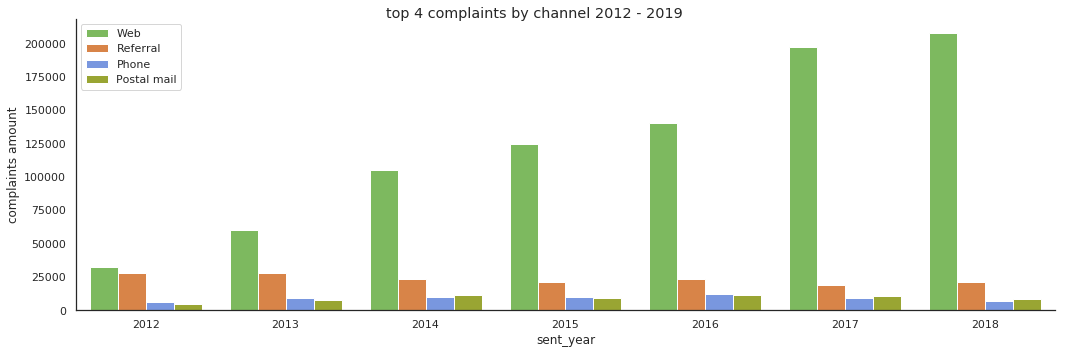

In [0]:
genBarchart("channel", "submitted_via")

###### 2.1.1.2 Which products get the most complaints? Have it changed over time?

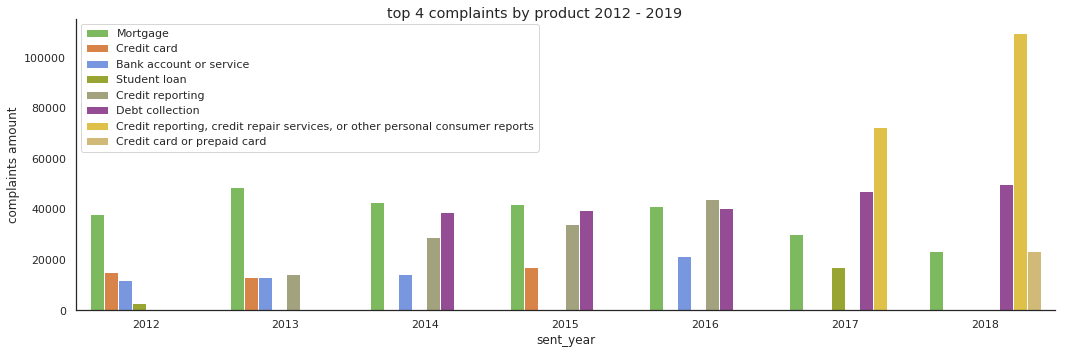

In [0]:
genBarchart("product", "product")

###### 2.1.1.3 Which companies got the most complaints? Have they improved over time?

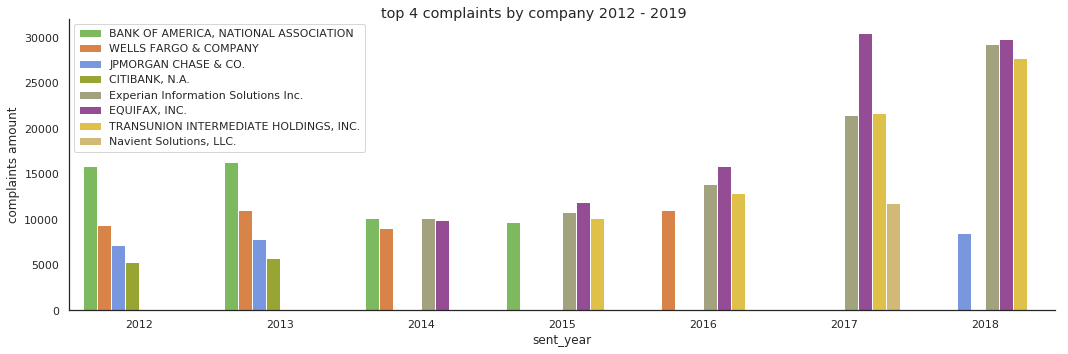

In [0]:
genBarchart("company", "company")

###### 2.1.1.4 Which companies got the most issues? Have they changed or improved over time?

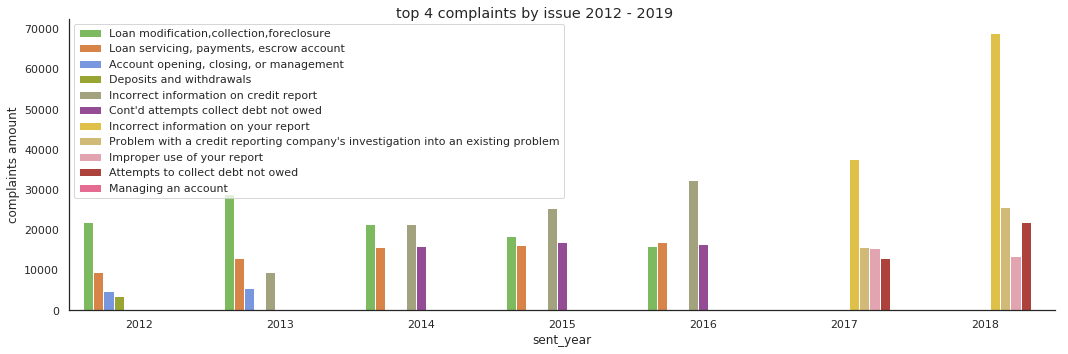

In [0]:
genBarchart("issue", "issue")

###### 2.1.1.5 Which states have the most complaints? Have they changed or improved over time?

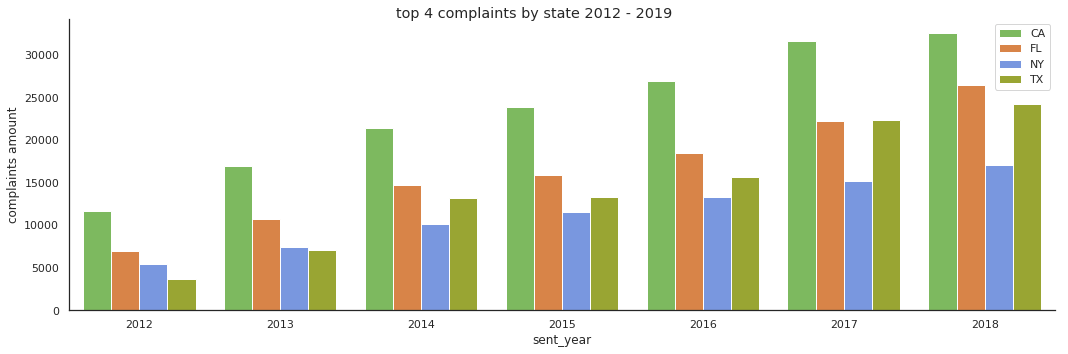

In [0]:
genBarchart("state", "state")

##### 2.1.1 Where are the complaints from
From annually top N rank of complaints amount by states, we can see
- the amount of complaints are all increased during the analysis period
- compare to the other top-ranked states which have shown slowdown in total complaints since 2017, the FL states shows rapid growth during the period given.
- the top N ranked states chart shows that the amount of complaints in the state is proportional to that of the population.

In [0]:
#group count by year by states and save the result to temp view: t_state_count
df_state_count = sqlContext.sql("SELECT year(date_received) as sent_year,state,count(1) AS count " + \
                  " FROM t_complaints " +\
                  " GROUP BY year(date_received),state")

- Show complaints distribution on the map.

In [0]:
df_state_count = sqlContext.sql("SELECT state,sum(count) AS value " + \
                  " FROM t_state_count WHERE state!='UNITED STATES MINOR OUTLYING ISLANDS' " +\
                  " GROUP BY state")
#stateRDD = sqlContext.createDataFrame(sc.parallelize())
#stateRDD.registerTempTable("test_state_table")

display(df_state_count)

##### 2.1.1 Top 4 complained products
- *Credit reporting, credit repair services, or other personal consumer reports*
- *Debt collection*
- *Mortgage*
- *Credit reporting*

In [0]:
df_product = sqlContext.sql("SELECT product,product_index,count(1) AS count " + \
                           " FROM t_complaints " +\
                           " GROUP BY product,product_index ORDER BY 3 DESC")
display(df_product)

##### 2.2.1 Checking sub-product to see what happened.
- There are two products refer to the Credit reporting, including **Credit reporting, credit repair services, or other personal consumer reports** and **Credit reporting**, and the sub product is **Credit reporting** or **Other personal consumer report** . Let's focus on credit report, and try to find what happened about this issue.
- 
Over 99% of these complaints are about Credit reporting

In [0]:
#filter those are credit report or consumer report related complaints
df_complaints_report = sqlContext.sql("SELECT product, sub_product,sub_product_index,count(1) AS count " + \
                           " FROM t_complaints " +\
                           " WHERE product_index in (0,3) " +\
                           " AND sub_product_index in (0,1,32) " +\
                           " GROUP BY product,sub_product,sub_product_index ORDER BY 4 DESC")
#save to table
df_complaints_report.createOrReplaceTempView('t_complaints_report')
display(df_complaints_report)

In [0]:
report_complaint_count = df_complaints_report.select(F.sum('count')).collect()[0][0]
#pd_count = pd.DataFrame(report_complaint_count, columns=report_complaint_count.columns
# almost 40% complaints is about credit reporting
#what's the proportion of these complaints, 32%, big
print((report_complaint_count/df_convert.count())*100)

##### 2.2.3 What's the issues about **Credit reporting**?
Among the nearly 40% of total complaints, what's the issues in it.
- There are many kinds of issues of these complaints data. Let's try to extract essential words from the detail of these issues.

In [0]:
# get narrative column
df_story = sqlContext.sql(\
                          " SELECT complaint_what_happened as content " +\
                          " FROM t_complaints WHERE " +\
                          #" product_index in (0,3) AND " +\
                          #" sub_product_index in (0,1,32) AND " +\
                          " complaint_what_happened IS NOT NULL AND " +\
                          " complaint_what_happened !='' ")

In [0]:
#可以只提取名词吗
vstopwords = np.append(stopwords,["x","xx","xxx","xxxx","xxxxx","xxxxxxxx","xx/xx/xxxx"])
#extract content from specific field of the dataframe, and return 
def parseContent(df_story, field_name):
  #lower 
  df_story_clean = df_story.select(field_name, (F.lower(F.regexp_replace(field_name, 
                                                                         "[^a-zA-Z\\s]", "")).alias('out1')))
  #split story into words
  tokenizer = Tokenizer(inputCol="out1", outputCol="out2")
  #private infor has been replaced with x before the dataset published, such as date, name...
  #remove stop words
  stopWordsRemover = StopWordsRemover(inputCol='out2', outputCol='out3' ,stopWords=stopwords)
  #stem
  stemmer = SnowballStemmer('english')
  udf_stem = udf(lambda words: [stemmer.stem(word) for word in words if len(word)>3 and word in english_words], ArrayType(StringType()))
  #pipeline
  pipeline = Pipeline(stages=[tokenizer, stopWordsRemover])
  return pipeline.fit(df_story_clean).transform(df_story_clean) \
      .select(field_name,"out3") \
      .drop("out1","out2") \
      .withColumn("words", udf_stem(F.col("out3"))).drop('out3')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data] Package words is already up-to-date!

In [0]:
df_words = parseContent(df_story,"content")
#explode words column and group count each word
df_word_count = df_words.select(explode("words").alias('word')).\
  groupby('word').count().sort(F.desc("count")).limit(100)

In [0]:
display(df_word_count)

word,count
credit,768328
account,646814
inform,380782
report,333288
would,322895
payment,315656
loan,301762
time,299642
receiv,289001
bank,262414


In [0]:
df.select(F.concat_ws('|','_c1','_c2','_c3','_c4')).show()


In [0]:
%matplotlib inline
#combine word and count column to map, and parse it to wordcloud
data = dict(zip(df_word_count.select('word').collect(), 
                df_word_count.select('count').collect()))
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)

--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-3688459704639835> in <module> 
 3 data = dict(zip(df_word_count.select('word').collect(), 
 4 df_word_count.select('count').collect()))
 ----> 5 wc = WordCloud ( width = 800 , height = 400 , max_words = 200 ) . generate_from_frequencies ( data ) 

 /databricks/python/lib/python3.7/site-packages/wordcloud/wordcloud.py in generate_from_frequencies (self, frequencies, max_font_size) 
 406 
 407 # largest entry will be 1 
 --> 408 max_frequency = float ( frequencies [ 0 ] [ 1 ] ) 
 409 
 410 frequencies = [(word, freq / max_frequency)

 TypeError : float() argument must be a string or a number, not 'Row'

We start with the **complaint_what_happened**, split the sentences into words tokenizer, and hash the sentences into a feature vector. and generate feature vectors for machine learning instead of using the text as features.

In [0]:
 
hashingTF = new HashingTF()
  .setInputCol("words").setOutputCol("rawFeatures").setNumFeatures(20)
lr = LogisticRegression(maxIter=7)
pipeline = Pipeline(stages=[hashingTF,lr])
# Fit the model to the data.
model = pipeline.fit(df_words)

# Given a dataset, predict each point's label, and show the results.
#model.transform(df_word).show()

File "<command-3688459704639838>" , line 2 
 hashingTF = new HashingTF() 
 ^
 SyntaxError : invalid syntax

In [0]:

hashingTF = new HashingTF()
  .setInputCol("words").setOutputCol("rawFeatures").setNumFeatures(20)
featurizedData = hashingTF.transform(df_story_clean)
idf = new IDF().setInputCol("rawFeatures").setOutputCol("features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.select("label", "features").show()

In [0]:
lr = LogisticRegression(maxIter=10)
# Fit the model to the data.
model = lr.fit(df)

# Given a dataset, predict each point's label, and show the results.
model.transform(df_word).show()

In [0]:

def apply_blob(sentence):
    temp = TextBlob(sentence).sentiment[0]
    if temp == 0.0:
        return 0.0 # Neutral
    elif temp >= 0.0:
        return 1.0 # Positive
    else:
        return 2.0 # Negative
sentiment = udf(apply_blob)
df_story.withColumn("sentiment", sentiment(df_story['complaint_what_happened'])).show()
      

##### 2.2.4 Which company contributed this issue most?
- Check how this issue distributed in within these companies. Have they dealed these complaints timely?
TRANSUNION INTERMEDIATE HOLDINGS, INC. , Experian Information Solutions Inc. and EQUIFAX, INC. have the highest count of complaints on this issue. By google these companies, we can find these are established for over 30 years financial company. Is this because they have a big consumer group?

##### 2.2.9 Let's generate words cloud to have a clear insight about the consumers' complaints
- split issue, sub_issue and narrative fields

##### Which company contributed this issue most?
- Check how this issue distributed in within these companies. Have they dealed these complaints timely?
TRANSUNION INTERMEDIATE HOLDINGS, INC. , Experian Information Solutions Inc. and EQUIFAX, INC. have the highest count of complaints on this issue. By google these companies, we can find these are established for over 30 years financial company. Is this because they have a big consumer group?

In [0]:
df_company_issue = sqlContext.sql("SELECT company,count(1) as count, " + \
                           " round((sum(IF(timely='No', 1, 0))/count(1))*100,2) as delay_percent " +\
                           " FROM t_complaints " +\
                           " WHERE PRODUCT='Credit reporting, credit repair services, or other personal consumer reports' " +\
                           " AND sub_product='Credit reporting' " +\
                           " AND issue='Incorrect information on your report' AND sub_issue='Information belongs to someone else' "\
                           " GROUP BY company")
display(df_company_issue)

###### How can we look further?
- Using web crawler, check the user amount of this company. 
- Checking the narrative, generating words cloud to see.
- From time aspect, check whether these issued have been fixed. 

These top 3 companies all have timely response, so this time let's only focus on the amount about this issue during these years. 
The line chart shows, from 2015 by now, this issue has been increased gradually instead of improved. Since 2020, the complaints amount increased greatly.

In [0]:
df_company_improve = sqlContext.sql("SELECT company,date_received,to_timestamp(date_received, 'yyyy-MM') as received_ym," + \
                           " count(1) as total "         
                           " FROM t_complaints " +\
                           " WHERE PRODUCT='Credit reporting, credit repair services, or other personal consumer reports' " +\
                           " AND sub_product='Credit reporting' " +\
                           " AND issue='Incorrect information on your report' AND sub_issue='Information belongs to someone else' "\
                           " AND ((company='TRANSUNION INTERMEDIATE HOLDINGS, INC.')  "
                           " OR (company='Experian Information Solutions Inc.')  "
                           " OR (company='EQUIFAX, INC.'))  "
                           " GROUP BY company,date_received,to_timestamp(date_received, 'yyyy-MM')")

display(df_company_improve)

#### By taking some sampling data, we have seen what the data looks like.
- **complaint_what_happened** is the description of what that consumer complained. By applying nlp related analysis, can we find the sentiment of these records. This is all about complaints, but there usually exists different levels of severity. If we can analysis these levels, it might be used for the future classification.
- Check the columns which have these standard items
- **date_received** and **date_sent_to_company** for applying time series analysis

- Clearing text from punctuation (regexp_replace)
 - Tokenization (Tokenizer)
 - Delete stop words (StopWordsRemover)
 - Stematization (SnowballStemmer)
 - Filtering short words (udf)

###NLP
-  DocumentAssembler(), one of the most essential transformers of the Spark NLP library. It’s the entry point to get your data in, and then process further with annotators. And, without linking its output to annotators in a pipeline, it has no meaning. In the following articles, we will talk about how you can apply certain NLP tasks on top of DocumentAssembler()

#### Where are these customers, in which way they complained.
 - using geo information to visualize the distribution of these consumers.
 - count the complaint record by source.

### 3 Machine Learning
- Can we predict the the sentiment of the consumers by extracting the story of these complaints.

In [0]:
df_zipcode = sqlContext.sql(" SELECT zip_code, count(1) as count FROM t_complaints GROUP BY zip_code")
#check correlation
"""
correlation_matrix = pd.merge(group1_df, group2_df, 
                              left_on='ZIPCODE', 
                              right_on='zipcode', 
                              how='inner')[['GROSS_SQUARE_FEET','price']].corr()

correlation_matrix

fig,ax = plt.subplots(figsize=(8, 2))
sns.heatmap(correlation_matrix, 
                annot=True,  fmt= '.2f')
fig.autofmt_xdate()
"""

Out[364]: "\ncorrelation_matrix = pd.merge(group1_df, group2_df, \n left_on='ZIPCODE', \n right_on='zipcode', \n how='inner')[['GROSS_SQUARE_FEET','price']].corr()\n\ncorrelation_matrix\n"

In [0]:
display(df_zipcode)

zip_code,count
921XX,2685
178XX,219
89106,100
94102,173
29210,166
18634,14
11722,155
068XX,873
92027,152
28117,132


#### 3.1 Feature processing
- Prepare features.

In [0]:
trainDF, testDF = df.randomSplit([0.8, 0.2], seed=42)
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())
#these are some categorical string columns, add according code column to make it easier to process
cat_columns = ['product','sub_product',\
               'issue','sub_issue',\
               'submitted_via','company','company_response',\
               'consumer_consent_provided','timely']
#pipeline
#indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(trainDF) for column in cat_columns ]
indexers = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in cat_columns]) 

pipeline = Pipeline(stages=indexers)
#coresponding *_index columns are added to the new dataframe
df_convert = pipeline.fit(df).transform(df)

- What's the distribution of the number of hours_per_week?
- How about education status?

In [0]:
display(trainDF.select("hours_per_week").summary())


display(trainDF
        .groupBy("education")
        .count()
        .sort("count", ascending=False))

In [0]:
display(trainDF
        .groupBy("education")
        .count()
        .sort("count", ascending=False))

#### 3.1 Definae the model
- Define the model.

#### 3.2 Buil the pipeline
- pipeline.....

#### 3.3 Evaluate the model
- pipeline.....

#### 3.4 Hyperparameter tuning
- tunning.....

#### 3.5 Make predictions and evaluate model performance
- prediction.....

In [0]:
/**
 * Step 3
 * Define a VectorAssembler transformer to transform source features data to be a vector
 * This is helpful when raw input data contains non-feature columns, and it is common for
 * such a input data file to contain columns such as "ID", "Date", etc.
 */
 val vectorAssembler = new VectorAssembler()
 .setInputCols(Array("f0","f1","f2","f3"))
 .setOutputCol("featureVector")

 /**
 * Step 4
 * Create RandomForestClassifier instance and set the input parameters.
 * Here we will use 5 trees Random Forest to train on input data.
 */
 val rfClassifier = new RandomForestClassifier()
 .setLabelCol("indexedLabel")
 .setFeaturesCol("featureVector")
 .setNumTrees(5)

 /**
 * Step 5
 * Convert indexed class labels back to original one so that it can be easily understood when we
 * need to display or save the prediction result to a file.
 */
 val labelConverter = new IndexToString()
 .setInputCol("prediction")
 .setOutputCol("predictedLabel")
 .setLabels(labelIndexer.labels)

 //Step 6
 //Randomly split the input data by 8:2, while 80% is for training, the rest is for testing.
 val Array(trainingData, testData) = df.randomSplit(Array(0.8, 0.2))

 /**
 * Step 7
 * Create a ML pipeline which is constructed by for 4 PipelineStage objects.
 * and then call fit method to perform defined operations on training data.
 */
 val pipeline = new Pipeline().setStages(Array(labelIndexer,vectorAssembler,rfClassifier,labelConverter))
 val model = pipeline.fit(trainingData)

 /**
 *Step 8
 *Perform predictions about testing data. This transform method will return a result DataFrame
 *with new prediction column appended towards previous DataFrame.
 *
 * */
 val predictionResultDF = model.transform(testData)

 /**
 * Step 9
 * Select features,label,and predicted label from the DataFrame to display.
 * We only show 20 rows, it is just for reference.
 */
 predictionResultDF.select("f0","f1","f2","f3","label","predictedLabel").show(20)

 /**
 * Step 10
 * The evaluator code is used to compute the prediction accuracy, this is
 * usually a valuable feature to estimate prediction accuracy the trained model.
 */
 val evaluator = new MulticlassClassificationEvaluator()
 .setLabelCol("label")
 .setPredictionCol("prediction")
 .setMetricName("precision")
 val predictionAccuracy = evaluator.evaluate(predictionResultDF)
 println("Testing Error = " + (1.0 - predictionAccuracy))
 /**
 * Step 11(Optional)
 * You can choose to print or save the the model structure.
 */
 val randomForestModel = model.stages(2).asInstanceOf[RandomForestClassificationModel]
 println("Trained Random Forest Model is:\n" + randomForestModel.toDebugString)
 }
}

##### 1.1.1 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.   + population
- input:big company, date, product type,least complained state
- output: state

less complaints=>more productive
- big company has sold A product. 100 people get it, 99%complained. than means product performs very bad here.
complaint rate of a product represent the performance of selling this product.

complaints /(product_sell_amount) =>performance

##### 1.1.2 With this model, the company can predict their new product campaingn strategy based on the least complaints and product type, date.  + population
- input:product,max complained state name, big company, date
- output: state
complaints rate!!!!不适合发布新产品

In [0]:
visualization
product==>least complaints /most complaints state 

预测是否max complaints
1、existing product==>which state wil have max complaints in  A specific 
基于历史数据最多抱怨的product 

In [0]:
# Register a UDF to convert the feature (2014_Population_estimate) column vector to a VectorUDT type and apply it to the column.
from pyspark.ml.linalg import Vectors, VectorUDT

spark.udf.register("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())
tdata = pop_df.select(*exprs).selectExpr("oneElementVec(2014_Population_estimate) as features", "2015_median_sales_price as label")

# Run a linear regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
modelA = lr.fit(tdata, {lr.regParam:0.0})

# Plot residuals versus fitted data
display(modelA, tdata)